# Analysis of how much data shuffling affects learning curves

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from scipy.stats import iqr
from glob import glob

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
from fit import * # weighted_power_law, fit_weighted_pwr_law
import rpy2.robjects as robjects

In [3]:
def calc_gof(y, yfit):
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [4]:
# Set Y axis
def set_yticks_ap(ax, ylim=None):
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if (ylim is None):
        ylim = ax.get_ylim()
    ylim_log = np.log2(ylim)
    ylabels_log = np.logspace(ylim_log[0], ylim_log[1], num=5, base=2)
    ylabels_log = np.around(ylabels_log, decimals=3)
    ax.set_yticks(ylabels_log)
    return ax

### Load results from runs

In [5]:
src = 'gdsc'
# src = 'top6'

# GDSC
if src == 'gdsc':
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_rf_100_trees')
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg0')

elif src == 'top6':
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_rf_100_trees')
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0')
    
elif src == 'ctrp':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees')
    
elif src == 'top21':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/multi_seed_lgbm_100_trees/trn.top21/split_on_cell/')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    
runs = glob(str(base_dir/'*'))

In [6]:
scores = []
# prf = 'id'
prf = 'run'

for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists():
        continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': prf+str(i)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if prf in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)
# scores_iqr    = iqr(scores.iloc[:, 6:].values, axis=0)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

# display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

# scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True)

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)
    scores_te.to_csv(base_dir/'scores.csv', index=False)

11
Training set sizes: [  128   256   512  1024  2048  4096  8192 16384 32768 65536 88416]


In [8]:
scores_te = scores_te.drop(columns=['run11'])

# LC all lin-lin

In [9]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

shift_idx=0
# shift_idx=1
# shift_idx=2
# shift_idx=3

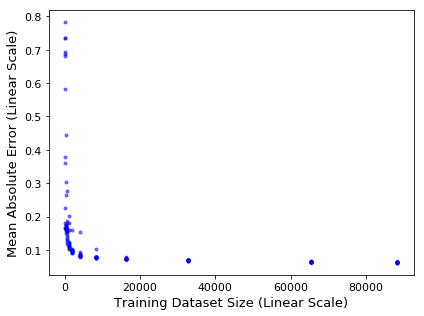

In [10]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

ax.tick_params(axis='both', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.savefig(base_dir/(f'{src}_all_runs_linlin.png'), dpi=200)

# LC all log-log

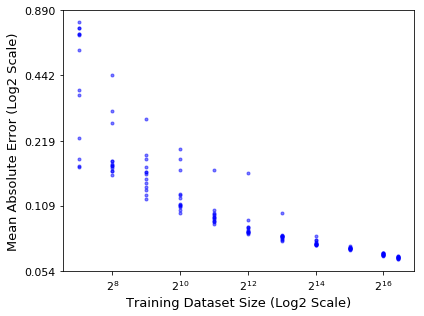

In [11]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

# print(ax.xaxis.get_major_locator())
# print(ax.yaxis.get_major_locator())
# print(ax.xaxis.get_major_formatter())
# print(ax.yaxis.get_major_formatter())

# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_all_runs_loglog.png'), dpi=200)

In [26]:
# Fit data
# pp_utils.fit_lc_multi_runs(runs, metric_name=metric_name, tr_set='te',
#                              shard_min_idx=shard_min_idx, cv_folds=1,
#                              xtick_scale=xtick_scale, ytick_scale=ytick_scale)

In [27]:
# x, y = get_xy(Path(runs[2]), metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1)
# ax = lrn_crv_plot.plot_lrn_crv_power_law(x=x, y=y, marker='.', alpha=0.7)

# LC of Median and STD across shuffles

In [12]:
plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'log2', 'figsize': figsize}

# The previous two figures should help decide which shards to use
scr = scores_te[shift_idx:].reset_index(drop=True)
y_col_name = 'median'

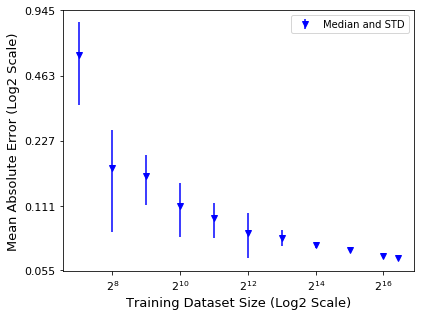

In [13]:
x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');
# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=10, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_avg_median_std.png'), dpi=200)

# Fit using all shards

GOF: {'rmse': 0.06365104784879963, 'mae': 0.028981086103384558}


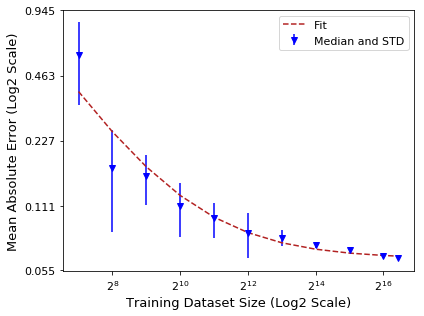

In [14]:
x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

# Median values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

# Fit
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fit')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_fit_using_all_shards.png'), dpi=200)

# Fit using subset of shards

GOF: {'rmse': 0.005994731950848704, 'mae': 0.003218046835875265}


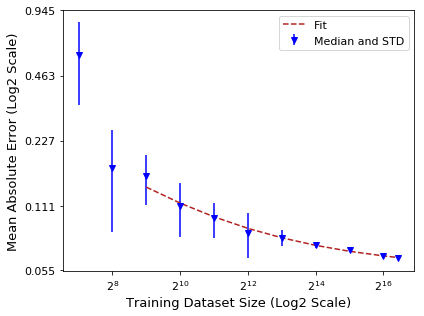

In [15]:
tot_pnts = len(x)
n_pnts_fit = 9 # Number of points to use for curve fitting starting from the largest size

x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

shard_min_id = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

# Median values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

# Fit
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fit')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_fit_using_subset_shards.png'), dpi=200)

# MAE vs Number of LC fit points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 11


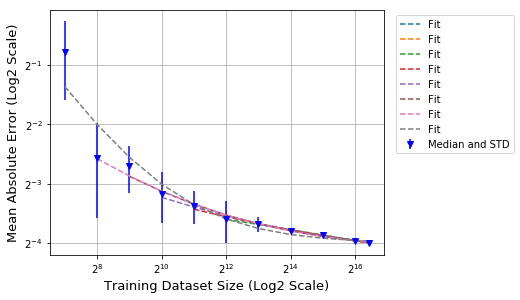

In [16]:
x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

tot_pnts = len(x)
print('tot_pnts', tot_pnts)
# min_points = 3  # 3 points doesn't work
min_pnts_fit = 4  # Min points to fit 
# max_pnts_fit = 9  # Min points to fit
max_pnts_fit = tot_pnts

p_arr = []
gof_arr = []
prm_arr = []

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');

for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
    shard_min_idx = tot_pnts - n_pnts_fit
    
    xf = x[shard_min_idx:]
    yf = y[shard_min_idx:]
    prms = fit_params(xf, yf)
    yfit = biased_powerlaw(xf, **prms)
    
    gof = calc_gof(yf, yfit)
    
    ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                       ax=ax, ls='--', marker='', alpha=1,
                                       **plot_args, label='Fit');
    
    prm_arr.append(prms)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)

In [17]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)
dd = dd.sort_values('mae')
display(dd[:3])

dd.to_csv(base_dir/'gof_vs_n_fit_pnts.csv', index=False)

,n_pnts,mae,rmse,alpha,beta,gamma
0,4,0.000219,0.000230,7.242145,-0.000800,-7.113448
2,6,0.000256,0.000352,0.186737,-0.067783,-0.023579
1,5,0.000291,0.000375,0.182137,-0.075019,-0.014792


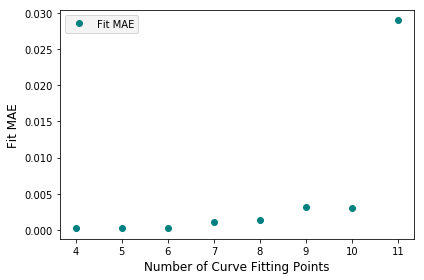

In [18]:
plot_beta = False
# plot_beta = True

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', color='teal', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

leg = lns1

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg.append(lns2)
    leg = lns1 + lns2
        
ax1.grid(True)

labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')

# ax.set_ylim([0.060, 0.150])
ax1.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_mae_prm_b_num_points.png'), dpi=200)

# Extrapolation

In [19]:
scr = scores_te.copy()
x = scr['tr_size'].values
y = scr['median'].values

# Define fitting range
tot_pnts = len(x)
xfit_min_id = 4
xfit_max_id = tot_pnts - 2

xf = x[xfit_min_id : xfit_max_id+1]
yf = y[xfit_min_id : xfit_max_id+1]
print(xf)
print('xfit_min_id={}, m={}'.format(xfit_min_id, x[xfit_min_id]))
print('xfit_max_id={}, m={}'.format(xfit_max_id, x[xfit_max_id]))

# Fit
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

# Fit GOF
fit_gof = calc_gof(yf, yfit)
print('Fit GOF:', fit_gof)

# Extrapolate
xext_id = tot_pnts - 1
xext = x[xext_id]
yext = biased_powerlaw(xext, **prms)
print('xext_id={}, m={}'.format(xext_id, xext))

# Extrap GOF
extrp_gof = calc_gof( [y[xext_id]], [yext] )
print('Extrp GOF:', extrp_gof)

# Extrapolate beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms)

[ 2048  4096  8192 16384 32768 65536]
xfit_min_id=4, m=2048
xfit_max_id=9, m=65536
Fit GOF: {'rmse': 0.001691963961183389, 'mae': 0.00113569607733881}
xext_id=10, m=88416
Extrp GOF: {'rmse': 0.0007221959023026442, 'mae': 0.0007221959023026442}


GOF: {'rmse': 0.06365104784879963, 'mae': 0.028981086103384558}


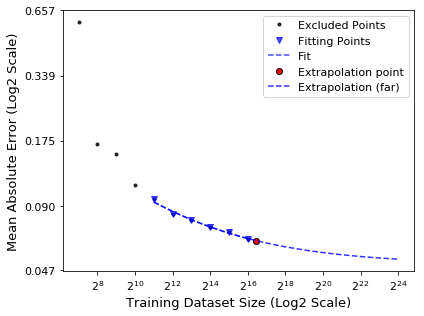

In [20]:
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

ax = None

# Plot all points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = x, y = y, # yerr = scr['std'],
        ax=ax, ls='', marker='.', alpha=0.8, color='k',
        **plot_args, label='Excluded Points')

# Plot fitting points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = xf, y = yf, # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='', marker='v', alpha=0.7, color='b',
        **plot_args, label='Fitting Points')

# Plot fit curve
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = xf, y = yfit, # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='--', marker='', alpha=0.7, color='b',
        **plot_args, label='Fit')

# Plot extrapolation point
ax.plot(xext, yext, 'o', color='r', markeredgecolor='k', alpha=1, label='Extrapolation point');

# Extrapolate beyond available size
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = xext_far, y = yext_far, # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='--', marker='', alpha=0.8, color='b',
        **plot_args, label='Extrapolation (far)')

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best')
plt.tight_layout()
ax.grid(False)

plt.savefig(base_dir/('{}_extrap_{}.png'.format(src, plot_args['ytick_scale'])), dpi=200)
print('GOF:', gof)